<h1>NYC Hospital Cost Analysis</h1>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

I imported data from NY State's SPARCS <a href="https://health.data.ny.gov/Health/Hospital-Inpatient-Cost-Transparency-Beginning-200/7dtz-qxmr">Hospital Inpatient Cost Transparency</a> dataset, collected from New York State hospitals from 2009-2014. The data describes discharges, costs, and charges for various diagnosis related groups (DRGs). Charges are the amounts billed for a procedure, whereas costs are the costs to the patient and/or their insurer. 

<i>Note that cost data are an estimate, as the costs calculated in this dataset are taken by multiplying the mean or median charge for a DRG by a hospital-level ratio of charges to cost.</i> For example, Hospital A may get about 50% of their billed charges back as revenue, so a DRG with a median charge of \$2,000 would result in a median cost of \$1,000. That \$1,000 is paid by the patient and their insurer based on the patient's plan. I imported the dataset along with a listing of NYC hospitals by permanent facility identifier (PFI) which allowed me to exclude non-NYC hospitals.

In [426]:
data = pd.read_csv('cost_data.csv')
nyc_hospitals = pd.read_csv('nyc_pfi.csv', encoding='latin1')
data.columns = ['year', 'pfi', 'name', 'drg', 'soi', 'description', 'soi_description',
                'medsurg_code', 'medsurg_desc', 'discharges', 'mean_chg', 'med_chg', 'mean_cost', 'med_cost']

The dataset has the following elements:
<ul>
<li><b>year:</b> The year of data collection</li>
<li><b>pif:</b> A unique identifier for New York hospitals</li>
<li><b>name:</b> The hospital's full name</li>
<br />
<li><b>drg:</b> All Patient Revised Diagnosis-Related Group code, a code that designates the type of procedure</li>
<li><b>soi:</b> Severity of illness on a scale from 1 to 4, 1 being minor and 4 being extreme</li>
<li><b>description:</b> The full name of the DRG</li>
<li><b>soi_description:</b> Severity of illness on a scale from Minor to Extreme</li>
<li><b>medsurg_code:</b> Designation of procedure as a medical (M) or surgical (P) procedure</li>
<li><b>medsurg_desc:</b> Full medical/surgical designation of procedure</li>
<li><b>discharges:</b> Number of patients treated within a DRG for a given year and hospital</li>
<br />
<li><b>mean_chg:</b> Mean charge for a DRG for a given year and hospital</li>
<li><b>med_chg:</b> Median charge for a DRG for a given year and hospital</li>
<li><b>mean_cost:</b> Mean cost for a DRG for a given year and hospital</li>
<li><b>med_cost:</b> Median cost for a DRG for a given year and hospital</li>
</ul>

I cleaned the data and filtered it to only include New York City hospitals. I also tagged each hospital by borough. I've displayed a random sample of the cleaned data below.

In [427]:
data = data[data['pfi'].isin(nyc_hospitals.pfi)]
data.ix[:,-4:] = data.ix[:,-4:].applymap(lambda x: float(x[1:]))
data = pd.merge(data, nyc_hospitals.ix[:,1:], on='pfi')
data.reset_index()
data.sample(6)

,year,pfi,name,drg,soi,description,soi_description,medsurg_code,medsurg_desc,discharges,mean_chg,med_chg,mean_cost,med_cost,borough
98026,2010,1305,Maimonides Medical Center,141,1,Asthma,Minor,M,Medical,154,17358.00,15800.00,5384.00,4901.00,Brooklyn
54699,2010,1165,Jacobi Medical Center,308,1,Hip & Femur Procedures For Trauma Except Joint...,Minor,P,Surgical,11,19963.00,18127.00,16496.00,14979.00,Bronx
154213,2013,1463,NYU Hospitals Center,894,3,HIV W One Signif HIV Cond Or W/O Signif Relate...,Major,M,Medical,4,40673.84,21237.73,7066.19,3903.06,Manhattan
169375,2011,1637,New York Hospital Medical Center of Queens,135,1,Major Chest & Respiratory Trauma,Minor,M,Medical,38,17213.12,12521.00,5542.95,4211.03,Queens
243948,2010,1692,Woodhull Medical & Mental Health Center,92,3,Facial Bone Procedures Except Major Cranial/Fa...,Major,P,Surgical,2,16573.00,16573.00,14219.00,14219.00,Brooklyn
90043,2013,1304,Lutheran Medical Center,691,2,"Lymphoma, Myeloma & Non-Acute Leukemia",Moderate,M,Medical,6,34268.15,30369.02,15010.72,12856.65,Brooklyn


The All-Patient Refined Diagnosis-Related Groups (APR-DRG) system uses 28 different codes to represent various neonate birthweights, conditions, and procedures. I decided to collapse those DRGs into two categories: one for a healthy birth and another to encompass all procedures, conditions, and abnormal birthweights.

In [428]:
neonate_abnormal = [583, 588, 589, 591, 593, 602, 603, 607, 608, 609, 611, 612, 613, 614, 621, 622, 623, 625, 626, 630, 631, 633, 634, 636, 639]
neonate_normal = [580, 581, 640]
data.ix[data.drg.isin(neonate_normal), 'description'] = 'Neonate, Normal'
data.ix[data.drg.isin(neonate_abnormal), 'description'] = 'Neonate, Underweight, Condition, or Procedure'

Next, I determined the most common surgical procedures per year at NYC area hospitals. By excluding the "Medical" tagged procedures, I determined the top surgical procedures by volume. Hip and knee replacements are notably high in volume.

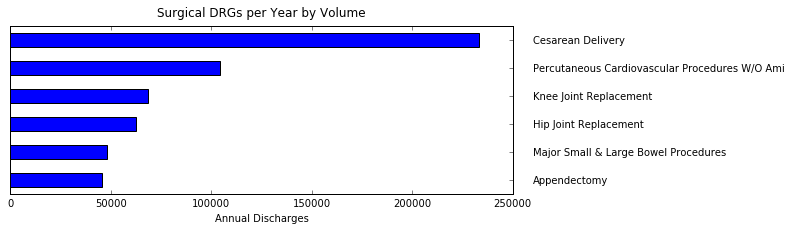

In [442]:
total_years = len(data.year.unique())
discharges = data[data['medsurg_code'] == 'P']['discharges'].groupby(data['description']).sum().sort_values(ascending=False).head(6)
    
f = plt.figure(1, figsize=(9,3))
ax = f.add_subplot(111)
ax.set_title('Surgical DRGs per Year by Volume', y=1.03)
ax = discharges.plot(kind='barh')
ax.invert_yaxis()
ax.yaxis.tick_right()
ax.set_yticklabels(ax.yaxis.get_majorticklabels(), ha = 'left')
ax.yaxis.set_tick_params(pad=20)
ax.set_ylabel('')
ax.set_xlabel('Annual Discharges')
plt.show()

I also determined the most expensive procedure categories based on median cost per year per procedure. Transplant surgeries dominate this list, costing patients and insurers tens and even hundreds of thousands of dollars.

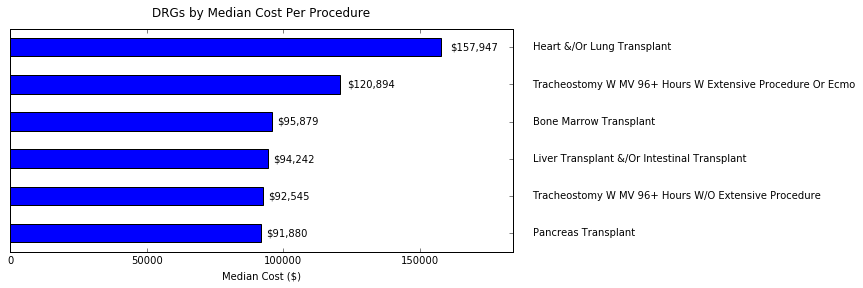

In [439]:
med_cost = data['med_cost'].groupby(data['description']).median().sort_values(ascending=False).head(6)
    
f = plt.figure(1, figsize=(9,4))
ax = f.add_subplot(111)
ax.set_title('DRGs by Median Cost Per Procedure', y=1.03)
ax = med_cost.plot(kind='barh')
ax.invert_yaxis()
ax.yaxis.tick_right()
ax.set_yticklabels(ax.yaxis.get_majorticklabels(), ha = 'left')
ax.yaxis.set_tick_params(pad=20)
ax.set_ylabel('')
ax.set_xlabel('Median Cost ($)')
ax.set_xlim(tuple(x * 1.15 for x in ax.get_xlim()))
for y, x in enumerate(med_cost):
        ax.annotate('$' + '{:,.0f}'.format(x), xy=(x*1.02,y), va='center')
plt.show()

I was curious to see how costs broke down across the five boroughs of NYC. Surprisingly, the Bronx came out on top. Many of NYC's specialty hospitals are located in Manhattan and the Bronx, so they are likely skewing the median cost of those boroughs. Still, Queens and Staten Island are cheaper across the board.

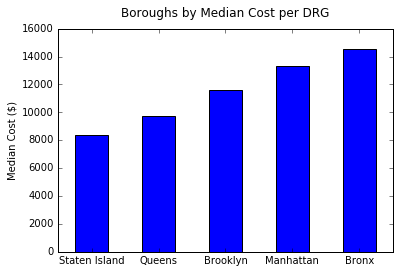

In [413]:
borough_cost = data['med_cost'].groupby(data['borough']).median().sort_values(ascending=False)

f = plt.figure(1, figsize=(6,4))
ax = f.add_subplot(111)
ax.set_title('Boroughs by Median Cost per DRG', y=1.03)
ax = borough_cost.plot(kind='bar', rot=0)
ax.invert_xaxis()
ax.set_xlabel('')
ax.set_ylabel('Median Cost ($)')
plt.show()

We can also examine the median cost at a facility level. Coler and Henry J. Carter are both specialty hospitals, so it's not surprising to see them top the list. Memorial Hospital for Cancer (aka Memorial Sloan Kettering) also makes sense on this list, as it is a premier cancer center and is internationally known. However, the hospitals in the Montefiore system are unexpected. Though Montefiore is an academic medical center, it is not a specialty hospital. This cost data suggest that Montefiore may be worth avoiding when possible due to its high median costs.

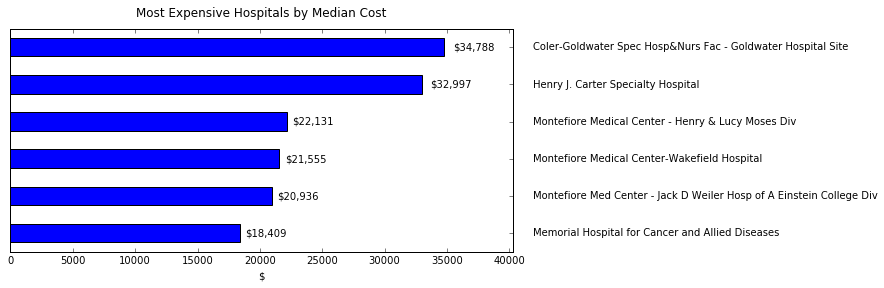

In [407]:
hospital_cost = data['med_cost'].groupby(data['name']).median().sort_values(ascending=False).head(6)

f = plt.figure(1, figsize=(9,4))
ax = f.add_subplot(111)
ax.set_title('Most Expensive Hospitals by Median Cost', y=1.03)
ax = hospital_cost.plot(kind='barh')
ax.invert_yaxis()
ax.yaxis.tick_right()
ax.set_yticklabels(ax.yaxis.get_majorticklabels(), ha = 'left')
ax.yaxis.set_tick_params(pad=20)
ax.set_ylabel('')
ax.set_xlabel('$')
ax.set_xlim(tuple(x * 1.15 for x in ax.get_xlim()))
for y, x in enumerate(hospital_cost):
        ax.annotate('$' + '{:,.0f}'.format(x), xy=(x*1.02,y), va='center')
plt.show()

Next, I defined a function to display a cost breakdown based on a DRG. This breakdown provides a box plot of the cost distribution, as well as the most or least expensive hospitals where that DRG is performed at least 30 times a year. We can increase the discharge threshold to exclude hospitals that only peripherally deal with the DRG.

In [403]:
def cost_of_procedure(drg, lowest=True):
    discharge_threshold = 30
    if isinstance(drg, list):
        proc = data[(data['drg'].isin(drg)) & (data['discharges'] > discharge_threshold)]
    else:
        proc = data[(data['drg'] == drg) & (data['discharges'] > discharge_threshold)]
    proc_med_cost = proc['med_cost'].groupby(data['name']).median().sort_values(ascending=lowest)
    proc_summary = proc_med_cost.describe()
    drg_description = proc.description.iloc[0]
    if lowest:
        title = 'Least Expensive Hospitals for ' + drg_description
    else:
        title = 'Most Expensive Hospitals for ' + drg_description
    
    # Describe the min, median, and max of costs for this DRG
    f1 = plt.figure(1, figsize=(9, 2))
    ax1 = f1.add_subplot(111)
    ax1.set_title('Cost Distribution for ' + drg_description, y=1.03)
    ax1.boxplot(proc_med_cost, vert=False, widths=0.4)
    ax1.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left='off',
        right='off',
        labelleft='off') # labels along the bottom edge are off
    plt.show()
    
    # Plot the top 10 most expensive hospitals for this DRG
    f2 = plt.figure(1, figsize=(9, 4))
    ax2 = f2.add_subplot(111)
    ax2.set_title(title, y=1.03)    
    ax2 = proc_med_cost.head(6).plot(kind='barh')
    ax2.invert_yaxis()
    ax2.yaxis.tick_right()
    ax2.set_yticklabels(ax2.yaxis.get_majorticklabels(), ha = 'left')
    ax2.yaxis.set_tick_params(pad=20)
    ax2.set_ylabel('')
    ax2.set_xlabel('$')
    ax2.set_xlim(tuple(x * 1.15 for x in ax2.get_xlim()))
    for y, x in enumerate(proc_med_cost.head(6)):
        ax2.annotate('$' + '{:,.0f}'.format(x), xy=(x*1.02,y), va='center')
    plt.show()

Here is the cost breakdown of a set of typical hernia procedures. With this data, we've determined the most affordable hospitals for hernia surgery in NYC. Here I displayed the <b>least</b> expensive hospitals for this DRG. Lincoln Medical and Mount Sinai - Queens Division seem to be outliers, as their costs for this procedure are much lower than what we see for other hospitals nearby in price.

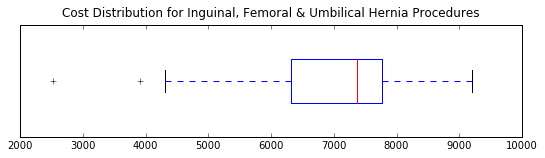

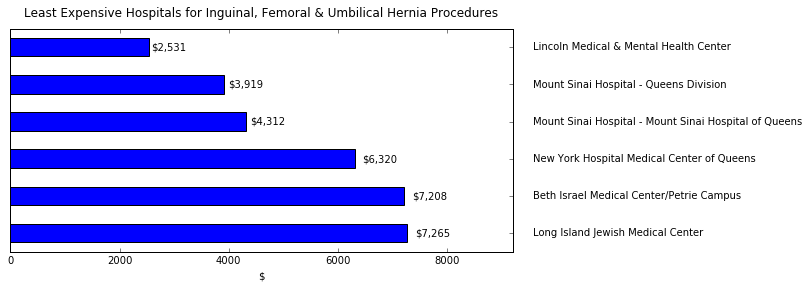

In [404]:
cost_of_procedure(228, lowest=True)

Here is the breakdown for a knee replacement. Observe the incredible $20K spread between the cheapest and most expensive hospitals. Here I displayed the <b>most</b> expensive hospitals for this DRG.

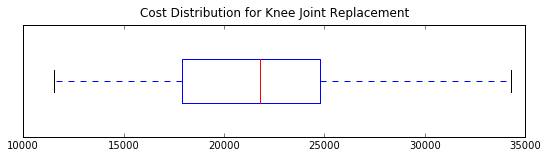

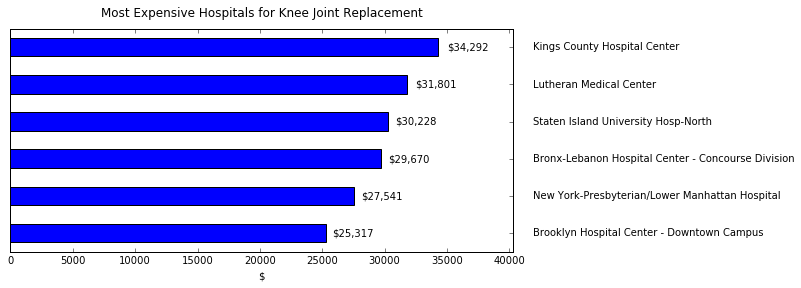

In [405]:
cost_of_procedure(302, lowest=False)

We can also look at the variation in cost for different procedures. Procedures that have a smaller <i>interquartile range</i> (the height of the box on the plot below) could potentially be targets for cash price negotiation, since most hospitals book approximately the same amount of revenue for that procedure. We might target cleft lip and palate repair procedures, for example, because the variability in cost is low across hospitals.

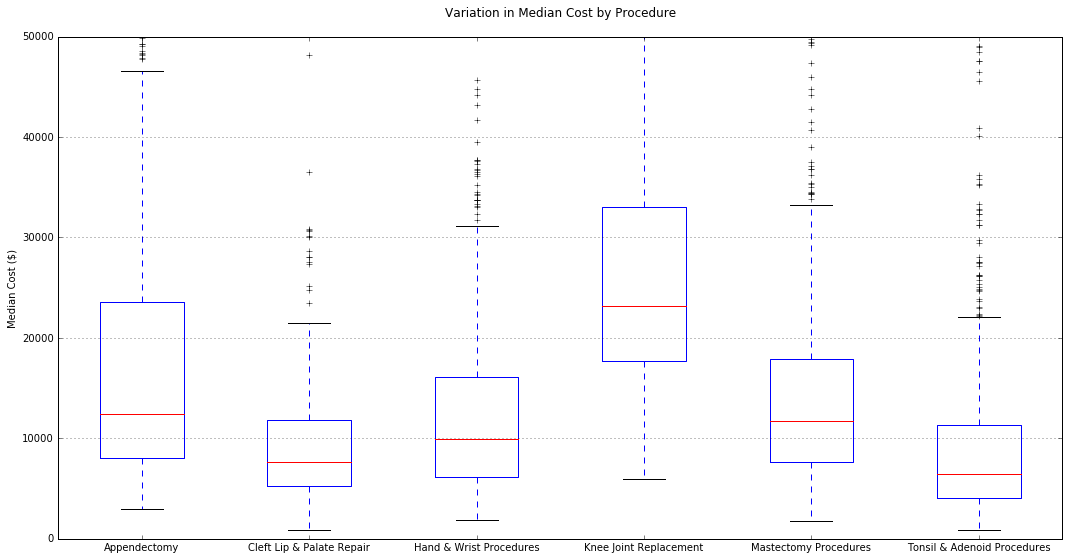

In [510]:
variance = data[data['drg'].isin([362, 316, 225, 95, 97, 302])][['description', 'med_cost']]
variance = variance.pivot(columns='description', values='med_cost')

f = plt.figure(1, figsize=(18, 9))
ax = f.add_subplot(111)
ax.set_ylim(0, 50000)
ax.set_ylabel('Median Cost ($)')
ax = variance.boxplot()
ax.set_title('Variation in Median Cost by Procedure', y=1.03)
ax.xaxis.grid(False)
plt.show()

Cost is only part of the equation when it comes to optimizing value in healthcare. Quality of care is another important component that is left out of this analysis. However, research has indicated that cost and quality are not correlated in the U.S. healthcare system. It is possible to obtain excellent care at a bargain price, if you know where to look. This tool provides visbility for costs in the NYC healthcare system at a near-procedure level and helps us understand specialties and procedures where the market is most inefficient.

<b>Potential expansion of this work:</b>
<ul>
<li>Build a tool that would show, for a given hospital, the five DRGs where the hospital is most competitive on price, and the five DRGs where the hospital is least competitive on price</li>
<li>Incorporate quality data or patient experience survey data to find hospitals that provide great quality for a low price (highest value)</li>
<li>Look at trends over time for costs for given procedures</li>
<li>Further investigate charge and cost data to understand opportunities for cash price negotiation.</li>
</ul>